<div style="
    color: blue; /* Text color */
    background-color: #f0f0f0; /* Light grey background */
    font-family: 'Pacifico', cursive; /* Stylish font */
    font-size: 40px; /* Font size */
    font-weight: bold; /* Bold text */
    padding: 20px; /* Padding around the text */
    border: 2px solid #ccc; /* Border with a light grey color */
    border-radius: 10px; /* Rounded corners */
    text-align: center; /* Centered text */
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); /* Subtle shadow */
    position: relative; /* Required for pseudo-elements positioning */
    display: inline-block; /* Inline-block for proper spacing */
">
    <span style="
        position: absolute; /* Absolute positioning */
        left: -40px; /* Positioning arrow on the left */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
    ML Modeling
    <span style="
        position: absolute; /* Absolute positioning */
        right: -40px; /* Positioning arrow on the right */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
</div>

<link href="https://fonts.googleapis.com/css2?family=Pacifico&display=swap" rel="stylesheet">


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


In [4]:
#df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data_Population_Normalized.csv")
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

In [5]:
print(df.columns)
print(df.shape)

Index(['week_no', 'iso_code', 'new_cases', 'new_deaths', 'new_vaccinations',
       'new_people_vaccinated', 'reproduction_rate', 'stringency_index',
       'excess_mortality', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population'],
      dtype='object')
(41184, 21)


In [6]:

df.drop(["iso_code", "week_no"], axis=1, inplace=True)
#df.drop(columns=df.columns[0:1], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41183, dtype: float64


In [7]:
# now we want to join datas together
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

for i in range(234):  # 234 is number of countries
    for j in range(176):  # 176 is number of weeks we have
        row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
        features_list.append(row_list)

for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


In [8]:
print(len(X_list))
print(len(Y_list))
np.shape(X_list)

40950
40950


(40950, 38)

In [9]:
# Here we are going to normalize the data.
from sklearn import preprocessing
x_df = pd.DataFrame(X_list)
min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

#df = pd.DataFrame(x_scaled)

In [10]:
import math

def train_test_splitter(X, Y, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / 234)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
    i = 0
    for i in range(234):
        j = 0
        for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
    return X_train, X_test, Y_train, Y_test

In [11]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list, prediction_days_count, 3, 10)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [13]:
print("X_train:", np.shape(X_train),
      ",X_val:" , np.shape(X_val),
      ",X_test:", np.shape(X_test),

      ",Y_train:" ,np.shape(Y_train),
      ",Y_val:", np.shape(Y_val),
      ",Y_test:", np.shape(Y_test)
      )

X_train: (30888, 38) ,X_val: (7722, 38) ,X_test: (1404, 38) ,Y_train: (30888, 1) ,Y_val: (7722, 1) ,Y_test: (1404, 1)


In [14]:
X_tr = np.array(X_train)
y_tr = np.array(Y_train).reshape(len(Y_train))
X_te = np.array(X_test)
y_te = np.array(Y_test).reshape(len(Y_test))
X_val = np.array(X_val)
y_val = np.array(Y_val).reshape(len(Y_val))

In [15]:
print("X_train:", np.shape(X_tr),
      ",X_val:" , np.shape(X_val),
      ",X_test:", np.shape(X_te),

      ",Y_train:" ,np.shape(y_tr),
      ",Y_val:", np.shape(y_val),
      ",Y_test:", np.shape(y_te)
      )

X_train: (30888, 38) ,X_val: (7722, 38) ,X_test: (1404, 38) ,Y_train: (30888,) ,Y_val: (7722,) ,Y_test: (1404,)


In [16]:
# Rescale predictions and true values back to original scale
def rescale_data(scaler, data):
    return scaler.inverse_transform(np.array(data).reshape(-1, 1)).flatten()

# Loss functions

In [17]:
def mean_square_error_sqrt (y_test, y_pred):
    return np.sqrt((np.sum(np.power(y_test - y_pred, 2)))/len(y_test))
def mean_absolute_error_self_defined (y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

# Modelling

## Importing loss functions

In [18]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error, d2_tweedie_score

## Model Evaluation

In [19]:
def plot_model(y_pred, y_test_rescaled, model_name, ax):
    ax.plot(np.arange(len(y_pred)), y_pred, label='Predicted')
    ax.plot(np.arange(len(y_pred)), y_test_rescaled, alpha=0.6, label='True')
    ax.set_title(f"{model_name} Predictions vs True Values")
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.legend()

In [20]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name, monitoring = True):
    y_pred_scaled = model.fit(X_train, y_train).predict(X_test)
    y_pred = rescale_data(scaler, y_pred_scaled)
    y_test_rescaled = rescale_data(scaler, y_test)

    # deviding by 10:
    y_pred /= 10
    y_test_rescaled /= 10

    # mae = mean_absolute_error_self_defined (y_test, y_pred_scaled)
    # mse = mean_square_error_sqrt(y_test, y_pred_scaled)
    
    mae = mean_absolute_error_self_defined (y_test_rescaled, y_pred)
    mse = mean_square_error_sqrt(y_test_rescaled, y_pred)
    # mape = mean_absolute_percentage_error(y_test_rescaled, y_pred)
    # rmse = mean_squared_error(y_test_rescaled, y_pred, squared=False)


    if monitoring ==True:
        print(f"Evaluating {model_name}")
        print(f"MAE: {mae}")
        print(f"MSE: {mse}")
        # print(f"MAPE: {mape}")
        # print(f"RMSE: {rmse}")
        # print(y_test_rescaled.type)
        # print()
        # print("Y_test:")
        # print(y_test_rescaled[:10])
        # print("Y_pred:")
        print(f"first 10 y_pred:\n {y_pred[:10]}")
        fig, axs = plt.subplots(1, 1, figsize=(18, 6))
        
        #plotting data
        plot_model(y_pred , y_test_rescaled , model_name , axs)
    else:
        return mae , mse , y_pred, y_test_rescaled

## SVR

In [21]:
from sklearn.svm import SVR

Evaluating SVR (rbf)
MAE: 2222.7981268369685
MSE: 2598.45391434201
first 10 y_pred
: [3475.66972329 3441.32098971 3357.60160067 3301.34029397 3311.66468725
 3261.30333657  667.25243599  266.08050446  398.62776806  434.00402807]
Evaluating SVR (linear)
MAE: 365248.40803274943
MSE: 365835.1298680434
first 10 y_pred
: [355590.5997575  355696.36737183 356064.84680167 356200.25287563
 356203.92141833 356417.07486172 354095.5227114  354109.2828579
 354137.35453887 354140.31549481]
Evaluating SVR (poly)
MAE: 373987.7110878953
MSE: 374399.6195399087
first 10 y_pred
: [368509.76669831 368598.27397456 368906.87690599 369024.31328994
 369027.9429175  369207.72026457 362492.18148584 362503.9415021
 362529.47947208 362533.11608665]


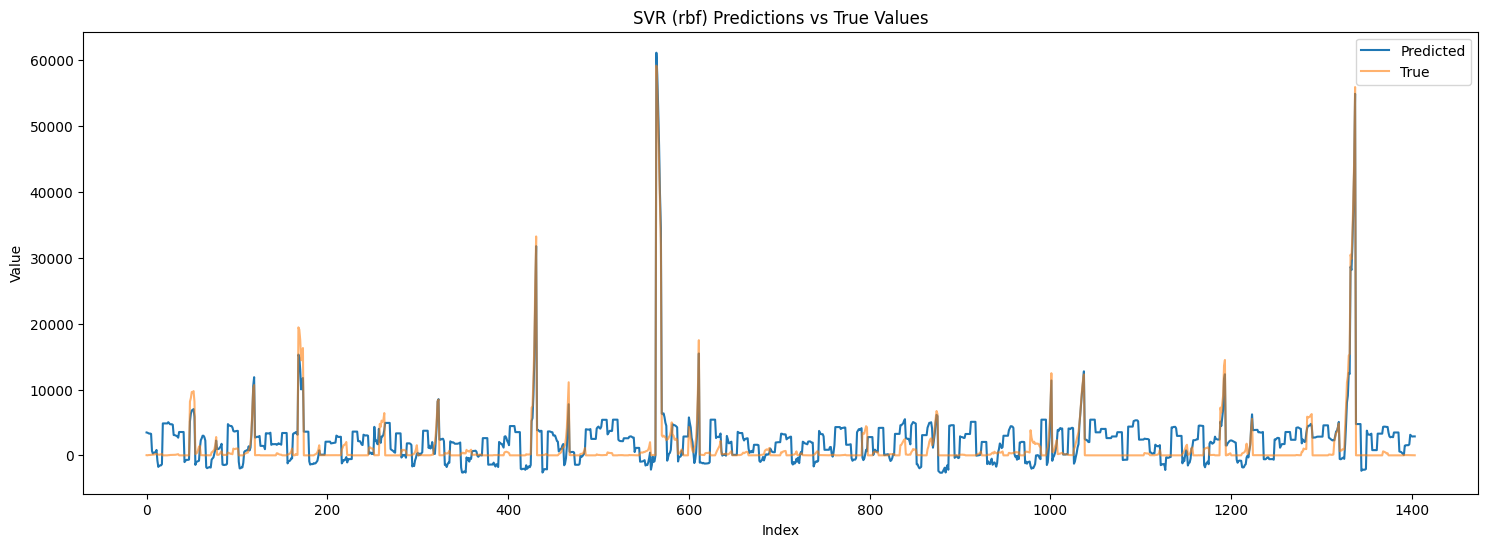

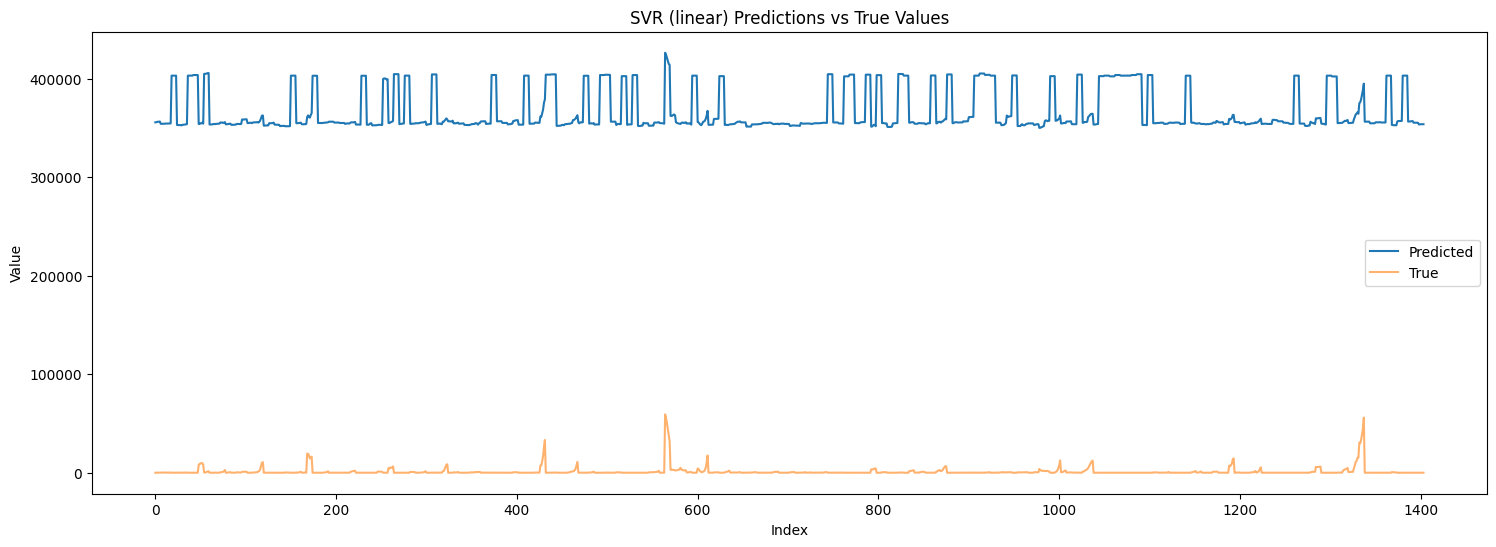

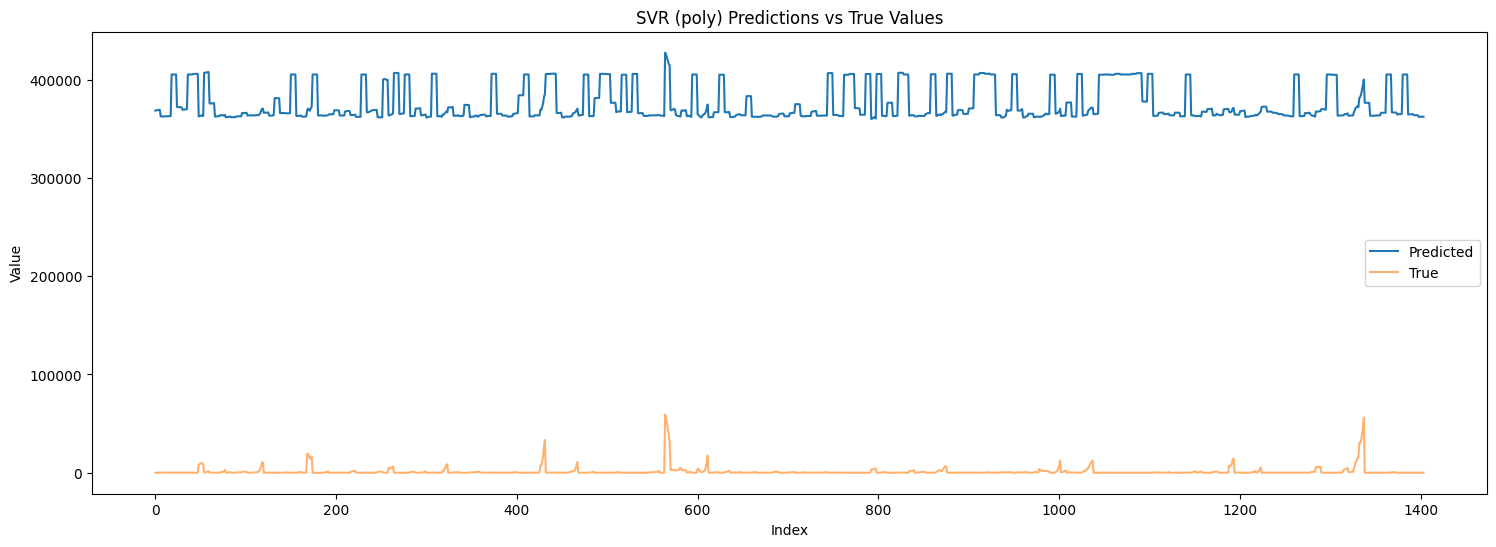

In [22]:
# Train and evaluate SVR models
svrs = [SVR(kernel="rbf", C=50, gamma=0.9, epsilon=0.001),
        SVR(kernel="linear", C=100, gamma="auto"),
        SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)]

for svr in svrs:
    evaluate_model(svr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name=f"SVR ({svr.kernel})")
    #evaluate_model(svr, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name=f"SVR ({svr.kernel})")


## KNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor

Evaluating KNeighborsRegressor
MAE: 506.6818376068376
MSE: 1788.2716983926352
first 10 y_pred
: [ 16.85  28.65  92.45  13.75  13.75  22.65 208.95 133.1  386.7  386.7 ]


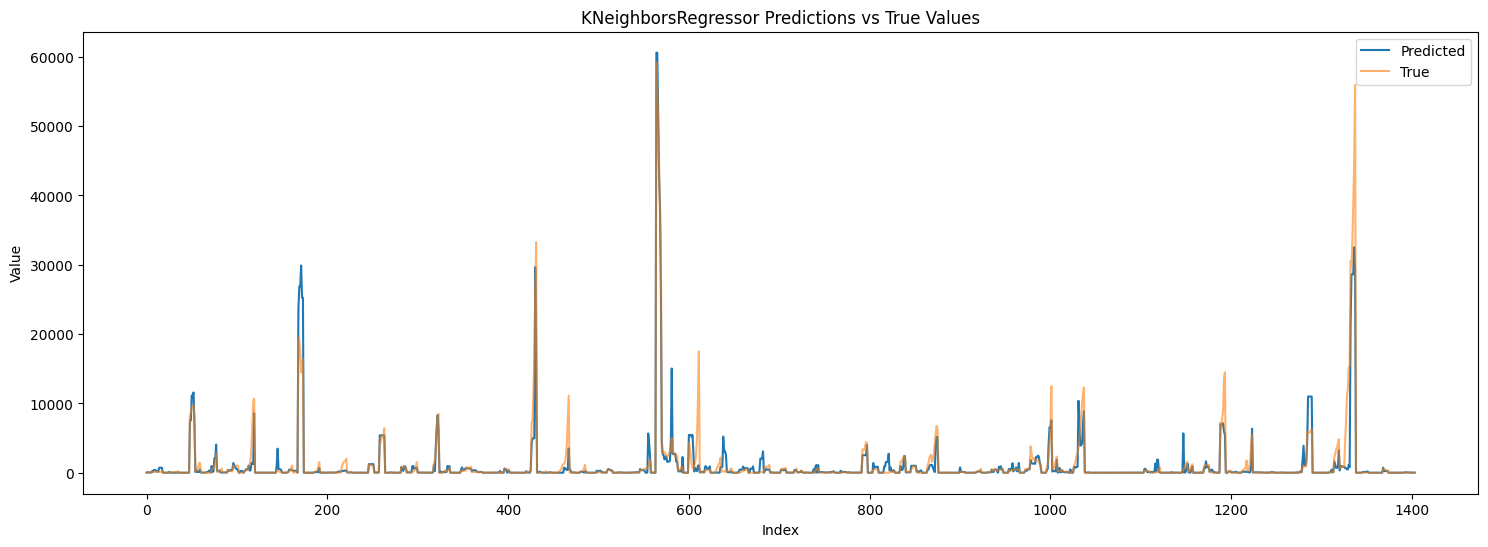

In [24]:
# Train and evaluate KNeighborsRegressor model
neigh = KNeighborsRegressor(n_neighbors=2, p=2)
evaluate_model(neigh, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="KNeighborsRegressor")
#evaluate_model(neigh, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="KNeighborsRegressor")


### Tuning

In [25]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

ks = [2, 5, 10, 15]
ps = [1,2,3 ]
results = []

for p in ps:
    for k in ks:

        neigh = KNeighborsRegressor(n_neighbors=k, p=p)
        model_err_pred = evaluate_model(neigh, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="KNeighborsRegressor", monitoring=False)
        
        # Append the results along with the k and p values
        results.append((k, p) + model_err_pred)
    
    #logging
    print(f"proccess for p = {p} done.", '\n')

# Convert the list of results to a DataFrame
columns = ["k", "p", "MAE", "MSE", "y_pred", "y_test_rescaled"]
tuning_data_df = pd.DataFrame(results, columns=columns)


proccess for p = 1 done. 

proccess for p = 2 done. 



proccess for p = 3 done. 



In [26]:
tuning_data_df

,k,p,MAE,MSE,y_pred,y_test_rescaled
0,2,1,495.767343,1944.471611,"[16.85, 16.85, 92.44999999999999, 13.75, 13.75...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
1,5,1,498.920228,1972.475254,"[27.880000000000003, 27.880000000000003, 48.42...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
2,10,1,546.419494,2165.101107,"[64.02, 64.02, 65.66999999999999, 67.53, 67.53...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
3,15,1,552.039269,2279.025712,"[50.16000000000001, 50.94666666666667, 78.1, 8...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
4,2,2,506.681838,1788.271698,"[16.85, 28.649999999999995, 92.44999999999999,...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
5,5,2,505.484074,1863.571038,"[27.880000000000003, 54.8, 168.06, 25.84000000...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
6,10,2,526.650207,1975.007954,"[64.02, 64.02000000000001, 147.85999999999999,...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
7,15,2,549.394036,2144.787659,"[54.02666666666668, 53.506666666666675, 126.02...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
8,2,3,528.940278,1810.290187,"[16.85, 28.649999999999995, 26.2, 13.75, 13.75...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
9,5,3,535.974587,1910.636381,"[27.880000000000003, 54.8, 168.06, 25.84000000...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."


for k=2 , p=1: MAE = 495.7673433048432 , MSE = 1944.4716113094555
for k=2 , p=2: MAE = 506.6818376068376 , MSE = 1788.2716983926352
for k=10 , p=3: MAE = 555.2186324786325 , MSE = 2015.9567347399359


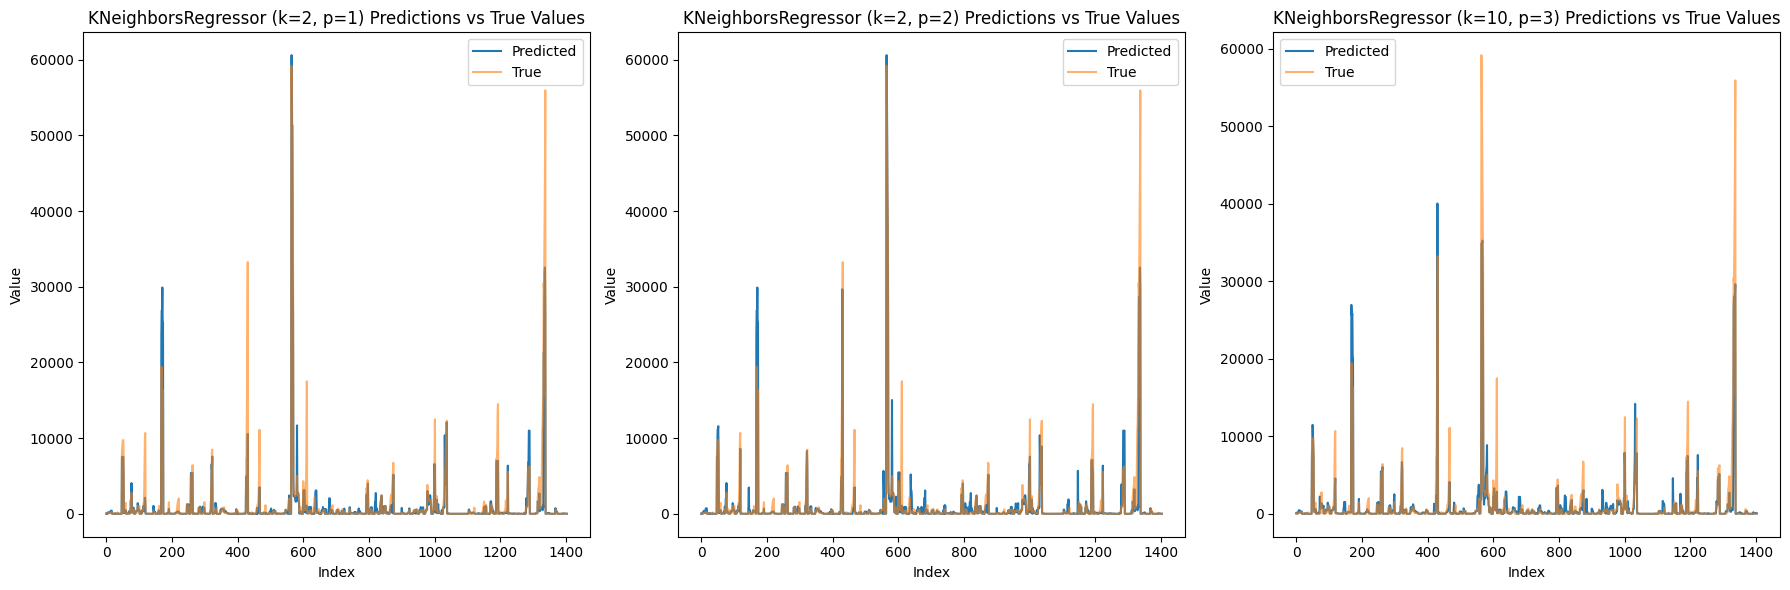

In [27]:
# Select three specific rows from tuning_data_df
rows_to_plot = [0, 4, 10]  # Adjust indices as needed to select different combinations of (k, p)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, row in enumerate(rows_to_plot):
    y_pred = tuning_data_df.loc[row, "y_pred"]
    k = tuning_data_df.loc[row, "k"]
    p = tuning_data_df.loc[row, "p"]
    y_test_rescaled = tuning_data_df.loc[row, "y_test_rescaled"]
    model_name = f"KNeighborsRegressor (k={k}, p={p})"
    print(f"for k={k} , p={p}: MAE = {tuning_data_df.loc[row, 'MAE']} , MSE = {tuning_data_df.loc[row, 'MSE']}")
    plot_model(y_pred, y_test_rescaled, model_name, axs[i])

plt.tight_layout()
plt.show()

## Polynomial

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR

Evaluating Polynomial Regression
MAE: 78.535258096883
MSE: 127.66563159899646
first 10 y_pred
: [ 46.35866253  29.7505649   52.43306981  63.11171417  78.64990597
  76.3988884  151.06348217 122.98655842 145.03991204 176.38187519]


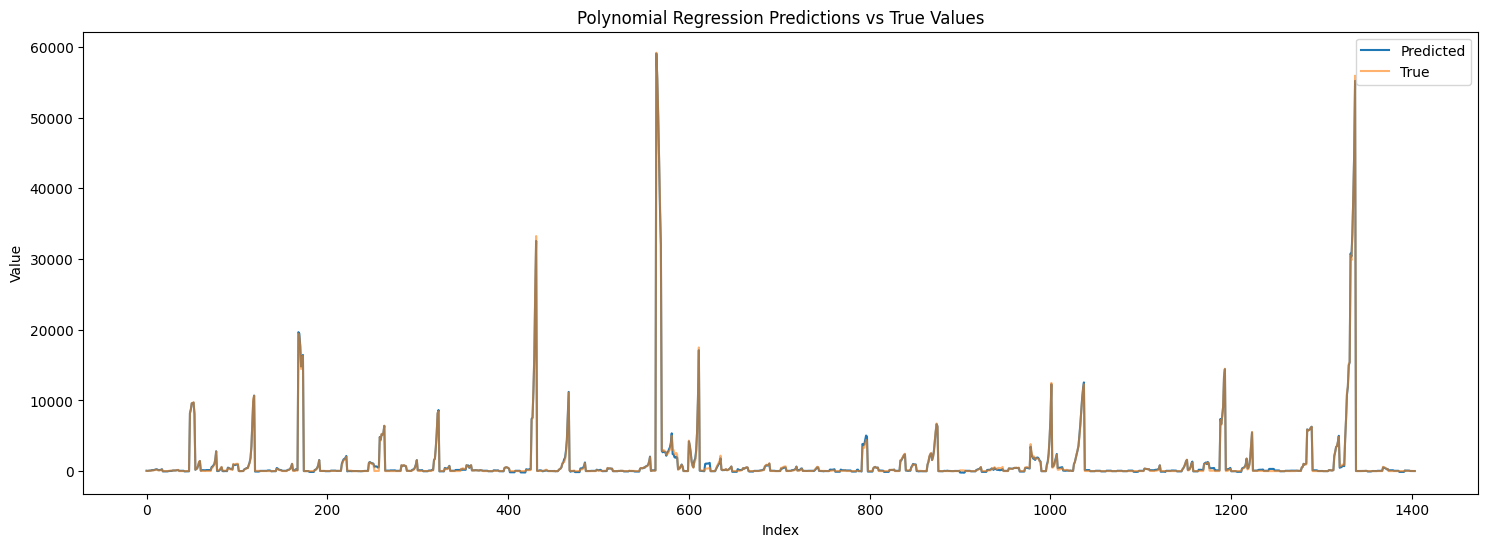

In [29]:
poly = PolynomialFeatures(degree=2)
X_poly_tr = poly.fit_transform(X_tr)
#X_poly_val = poly.transform(X_val)
X_poly_te = poly.transform(X_te)

linear_model = LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42)
#evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_val, y_val, min_max_scaler_Y, model_name="Polynomial Regression")
evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_te, y_te, min_max_scaler_Y, model_name="Polynomial Regression")

### Tuning 


<span style="color: red;">
it seems that this model with degree 2 is fit enogh. higher degrees has a huge process load. plus they have no better result.

</span>

## AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

Evaluating AdaBoostRegressor
MAE: 2546.0747916946098
MSE: 3900.1011898066135
first 10 y_pred
: [2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148
 2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148]


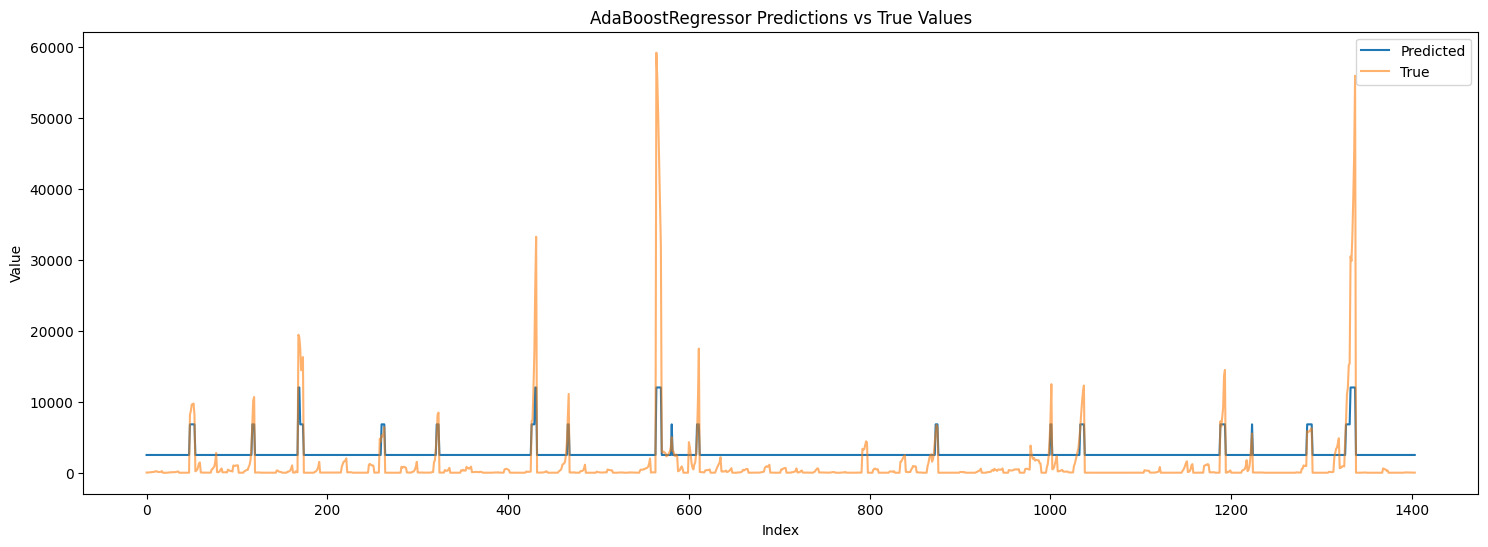

In [31]:
# Train and evaluate AdaBoostRegressor model
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="AdaBoostRegressor")

### Tuning 


Evaluating AdaBoostRegressor
MAE: 2546.0747916946098
MSE: 3900.1011898066135
first 10 y_pred
: [2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148
 2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148]
process for degree 1 done.
process for degree 2 done.
process for degree 3 done.


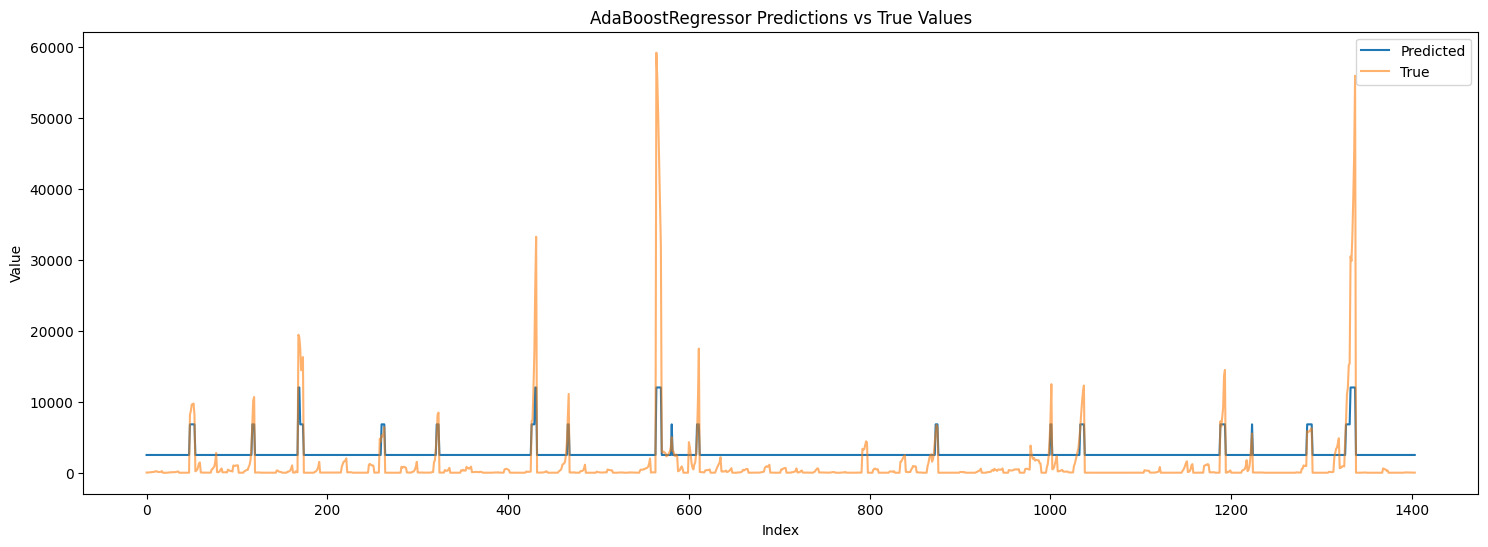

In [32]:
degrees = [1,2,3]
results = []

# Train and evaluate AdaBoostRegressor model
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="AdaBoostRegressor")

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_tr = poly.fit_transform(X_tr)
    #X_poly_val = poly.transform(X_val)
    X_poly_te = poly.transform(X_te)

    linear_model = LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42)
    #evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_val, y_val, min_max_scaler_Y, model_name="Polynomial Regression")
    evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_te, y_te, min_max_scaler_Y, model_name="Polynomial Regression", monitoring=False)

    results.append((degree,) + model_err_pred)

    print(f"process for degree {degree} done.")

# Convert the list of results to a DataFrame
columns = ["Degree", "MAE", "MSE", "y_pred", "y_test_rescaled"]
tuning_data_df = pd.DataFrame(results, columns=columns)


## Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

Evaluating RandomForestRegressor
MAE: 455.9947120995119
MSE: 751.0454963440693
first 10 y_pred
: [308.58380774 308.58380774 308.58380774 308.58380774 308.58380774
 308.58380774 308.58380774 308.58380774 308.58380774 308.58380774]


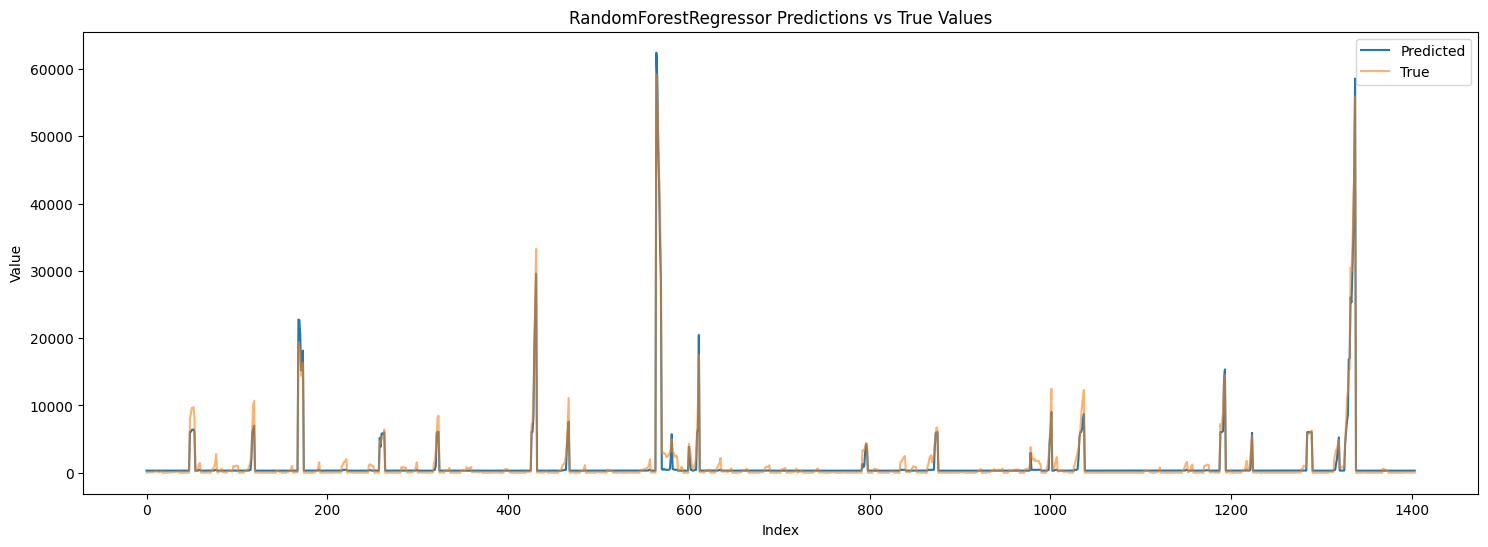

In [34]:
# Train and evaluate RandomForestRegressor model
regr = RandomForestRegressor(max_depth=4, random_state=0)
#evaluate_model(regr, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="RandomForestRegressor")
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="RandomForestRegressor")

### Tuning

In [35]:
'''def tune_model ( model , hyper_parameters , ):
    results = []

    for parameter in hyper_parameters:
        if model == "RandomForestRegressor":
            regr = RandomForestRegressor(max_depth=parameter, random_state=0)
        elif model== "AdaBoostRegressor"
        model_err_pred = evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="RandomForestRegressor")

        results.append((parameter,) + model_err_pred)

        print(f"process for degree {parameter} done.")

    # Convert the list of results to a DataFrame
    columns = [f"{parameter}", "MAE", "MSE", "y_pred", "y_test_rescaled"]
    tuning_data_df = pd.DataFrame(results, columns=columns)
    return tuning_data_df'''

"this is a function which is not complete. also doesn't have enough Universality to cover all models. but I remain this here maybe for future"

"this is a function which is not complete. also doesn't have enough Universality to cover all models. but I remain this here maybe for future"

In [36]:
max_depths = [2,3,4,5,6,7,8,9]
results = []

for depth in max_depths:
    # Train and evaluate RandomForestRegressor model
    regr = RandomForestRegressor(max_depth=depth, random_state=0)
    #evaluate_model(regr, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="RandomForestRegressor")
    model_err_pred = evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="RandomForestRegressor", monitoring=False)

    results.append((depth,) + model_err_pred)

    print(f"process for depth {depth} done.")

# Convert the list of results to a DataFrame
columns = ["depth", "MAE", "MSE", "y_pred", "y_test_rescaled"]
tuning_data_df = pd.DataFrame(results, columns=columns)


process for depth 2 done.
process for depth 3 done.
process for depth 4 done.
process for depth 5 done.
process for depth 6 done.
process for depth 7 done.
process for depth 8 done.
process for depth 9 done.


In [37]:
tuning_data_df

,depth,MAE,MSE,y_pred,y_test_rescaled
0,2,1749.778965,3999.068144,"[1261.596801904244, 1261.596801904244, 1261.59...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
1,3,961.880111,1815.638565,"[665.4686712830764, 665.4686712830764, 665.468...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
2,4,455.994712,751.045496,"[308.5838077415311, 308.5838077415311, 308.583...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
3,5,189.355731,263.656789,"[129.86263072864168, 129.86263072864168, 129.8...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
4,6,67.984552,95.316484,"[48.90765761898556, 48.90765761898556, 48.9076...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
5,7,30.136061,49.312651,"[23.420555235027063, 23.420555235027063, 23.42...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
6,8,15.649832,25.437228,"[33.77287582902984, 33.77287582902984, 33.7728...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."
7,9,10.153537,16.906174,"[36.19072071628285, 36.19072071628285, 36.1907...","[27.3, 10.500000000000002, 40.6, 43.8, 62.7, 6..."


<span style="color: red;">
  as you can see, errors for higher depths are lower.

</span>


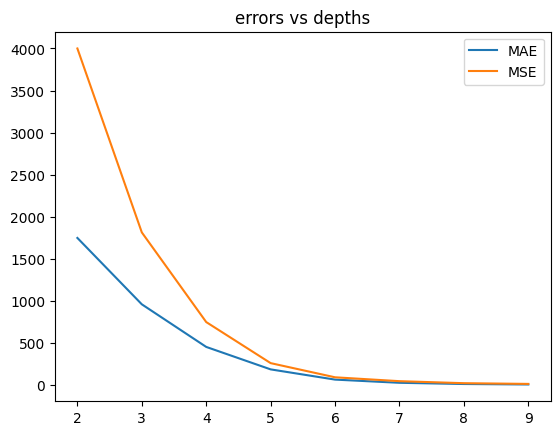

In [38]:
plt.plot(tuning_data_df["depth"] , tuning_data_df["MAE"], label='MAE')
plt.plot(tuning_data_df["depth"] , tuning_data_df["MSE"] ,label='MSE')
plt.legend()
plt.title("errors vs depths")
plt.show()


<div style="
    color: red; /* Text color */
    background-color: #f0f0f0; /* Light grey background */
    font-family: 'Pacifico', cursive; /* Stylish font */
    font-size: 20px; /* Font size */
    font-weight: bold; /* Bold text */
    padding: 20px; /* Padding around the text */
    border: 2px solid #ccc; /* Border with a light grey color */
    border-radius: 10px; /* Rounded corners */
    text-align: center; /* Centered text */
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); /* Subtle shadow */
    position: relative; /* Required for pseudo-elements positioning */
    display: inline-block; /* Inline-block for proper spacing */
">
    <span style="
        position: absolute; /* Absolute positioning */
        left: -40px; /* Positioning arrow on the left */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: green; /* Arrow color */
    ">➤</span>
      it seems that errors converge. because of process load we can use depth = 6.
    <span style="
        position: absolute; /* Absolute positioning */
        right: -40px; /* Positioning arrow on the right */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: green; /* Arrow color */
    ">➤</span>
</div>

<link href="https://fonts.googleapis.com/css2?family=Pacifico&display=swap" rel="stylesheet">


for depth = 2: MAE = 1749.7789650489258 , MSE = 3999.068143557473
for depth = 6: MAE = 67.98455198095004 , MSE = 95.3164836681666
for depth = 9: MAE = 10.153536744868681 , MSE = 16.906173784119424


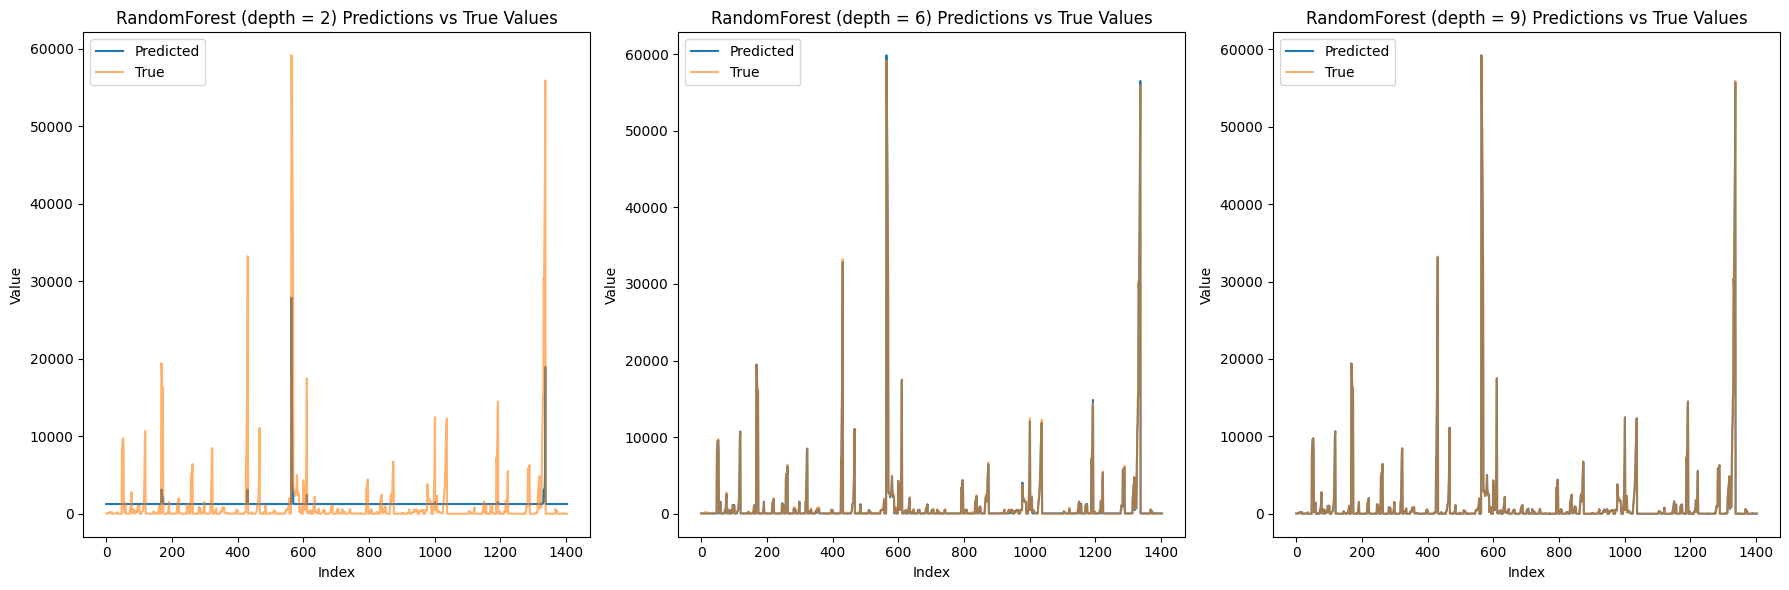

In [39]:
# Select three specific rows from tuning_data_df
rows_to_plot = [0, 4, 7] 

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, row in enumerate(rows_to_plot):
    y_pred = tuning_data_df.loc[row, "y_pred"]
    depth = tuning_data_df.loc[row, "depth"]
    y_test_rescaled = tuning_data_df.loc[row, "y_test_rescaled"]
    model_name = f"RandomForest (depth = {depth})"
    print(f"for depth = {depth}: MAE = {tuning_data_df.loc[row, 'MAE']} , MSE = {tuning_data_df.loc[row, 'MSE']}")
    plot_model(y_pred, y_test_rescaled, model_name, axs[i])

plt.tight_layout()
plt.show()

## Stacking

In [40]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

Evaluating StackingRegressor
MAE: 44.33629197846652
MSE: 147.0270767189279
first 10 y_pred
: [ 12.46419349  10.37419349  11.39572367  11.8045653   29.44572367
  69.09229715  97.44666667  66.628       55.15966667 122.03      ]


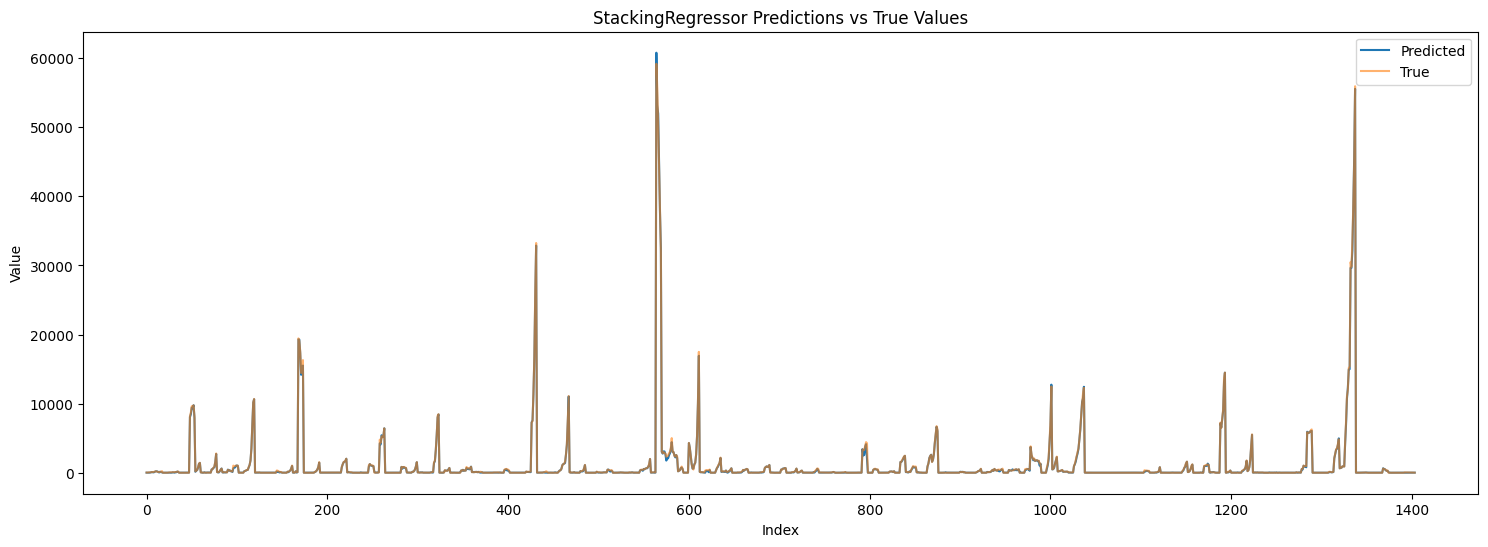

In [41]:
# Train and evaluate StackingRegressor model
estimators = [('lr', RidgeCV()), ('svr', LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42))]
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))
#evaluate_model(reg, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name="StackingRegressor")
evaluate_model(reg, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="StackingRegressor")

### Tuning

Evaluating AdaBoostRegressor
MAE: 2546.0747916946098
MSE: 3900.1011898066135
first 10 y_pred
: [2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148
 2501.71635148 2501.71635148 2501.71635148 2501.71635148 2501.71635148]
process for degree 1 done.
process for degree 2 done.
process for degree 3 done.


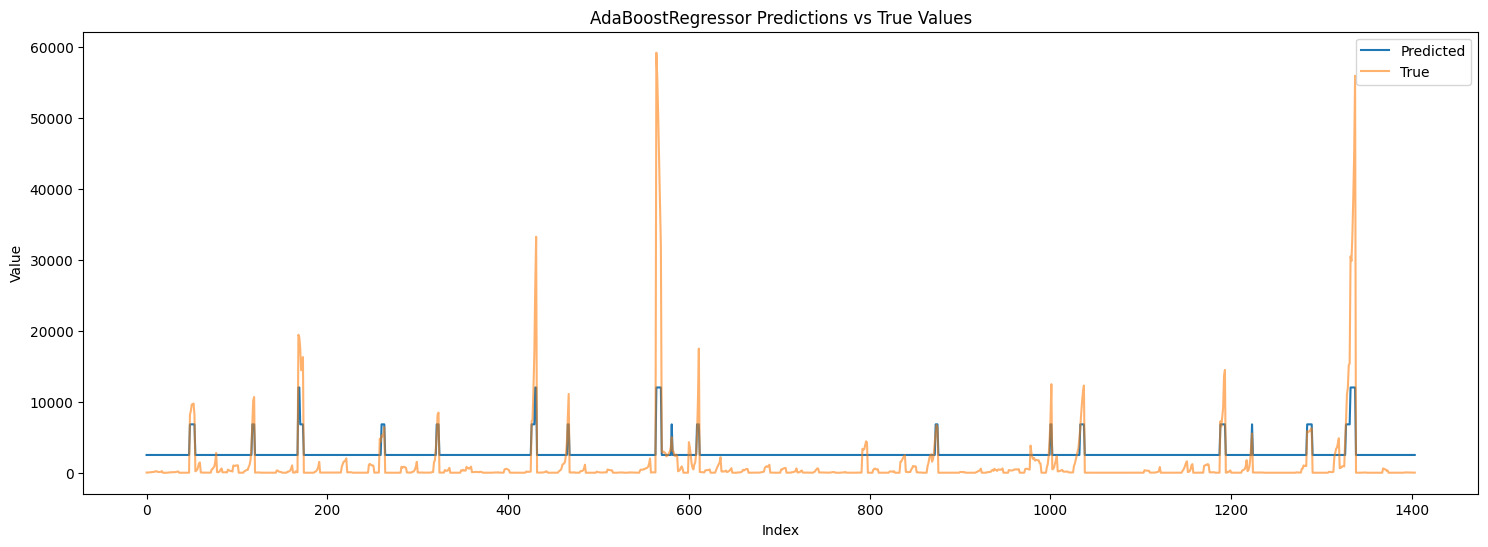

In [42]:
degrees = [1,2,3]
results = []

# Train and evaluate AdaBoostRegressor model
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="AdaBoostRegressor")

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_tr = poly.fit_transform(X_tr)
    #X_poly_val = poly.transform(X_val)
    X_poly_te = poly.transform(X_te)

    linear_model = LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42)
    #evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_val, y_val, min_max_scaler_Y, model_name="Polynomial Regression")
    evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_te, y_te, min_max_scaler_Y, model_name="Polynomial Regression", monitoring=False)

    results.append((degree,) + model_err_pred)

    print(f"process for degree {degree} done.")

# Convert the list of results to a DataFrame
columns = ["Degree", "MAE", "MSE", "y_pred", "y_test_rescaled"]
tuning_data_df = pd.DataFrame(results, columns=columns)



# Tuning Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")


df.drop(["iso_code", "week_no"], axis=1, inplace=True)
#df.drop(columns=df.columns[0:1], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

# now we want to join datas together
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

for i in range(234):  # 234 is number of countries
    for j in range(176):  # 176 is number of weeks we have
        row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
        features_list.append(row_list)

for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])



new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41183, dtype: float64


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

class Moldels_Tuning (object):
    def __init__ (self, X_list, Y_list, prediction_days_count, \
                  batch_count, batch_length, val_size, loss = "mse"):
        x_df = pd.DataFrame(X_list)
        self._min_max_scaler_X = preprocessing.MinMaxScaler()
        x_scaled = self._min_max_scaler_X.fit_transform(x_df)
        
        y_df = pd.DataFrame(Y_list)
        self._min_max_scaler_Y = preprocessing.MinMaxScaler()
        y_scaled = self._min_max_scaler_Y.fit_transform(y_df)
        
        X_scaled_list = x_scaled.tolist()
        Y_scaled_list = y_scaled.tolist()
        
        self._X_train, self._X_test, self._Y_train, self._Y_test = self.__train_test_splitter (X_scaled_list, Y_scaled_list, prediction_days_count, batch_count, batch_length)
        self._val_size = val_size
        self._loss = loss.lower()

        # initial values
        # svm
        self.svm_rbf_min_loss_params_ = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        self.svm_rbf_losses_ = []
        self.svm_linear_min_loss_params_ = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        self.svm_linear_losses_ = []
        self.svm_poly_min_loss_params_ = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        self.svm_poly_losses_ = []

        # KNN
        self.KNN_min_loss_params_ = {"n_neighbor": None,
                          "p": None,
                          "weight": None,
                          "algorithm": None,
                          "leaf_size": None,
                          "min_loss_value": None}
        self.KNN_losses_ = []
        # Ada Bosst
        self.Ada_Boost_min_loss_params_ = {"n_estimator" : None,
                            "learning_rate" : None,
                            "random_state" : None,
                            "estimator" : None,
                            "min_loss_value" : None}
        self.Ada_Bosst_losses_ = []

        # Poly
        self.Poly_min_loss_params_ = {"degree": None,
                              "interaction_only": None,
                              "include_bias": None,
                              "min_loss_value": None}
        self.Poly_losses_ = []
    
        # Random Forrest:
        self.random_forrest_min_loss_params_ = {"n_estimator" : None,
                                "max_depth" : None,
                                "min_samples_split" : None,
                                "min_samples_leaf" : None,
                                "bootstrap" : None,
                                "random_state" : None,
                                "max_features" : None,
                                "min_loss_value" : None}
        self.random_forrset_losses_ = []
    
    def __train_test_splitter(self, X, Y, prediction_days_count, batch_count, batch_length):
        xlen = len(X)
        xs_count_for_each_country = int(xlen / 234)
        X_train = []
        X_test = []
        Y_train = []
        Y_test = []
        steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
        i = 0
        for i in range(234):
            j = 0
            for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
                X_train.append(X[j])
                Y_train.append(Y[j])
            while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
                for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                    X_test.append(X[k])
                    Y_test.append(Y[k])
                j += batch_length
                for k in range(j, j + steps):
                    X_train.append(X[k])
                    Y_train.append(Y[k])
                j += steps + 1
                while j < (i+1) * xs_count_for_each_country:
                    X_train.append(X[j])
                    Y_train.append(Y[j])
                    j += 1
        return X_train, X_test, Y_train, Y_test
    

    def __train_val_spliter (self, seed=0):
        X_train, X_val, Y_train, Y_val = train_test_split(self._X_train, self._Y_train, \
                                                          test_size=self._val_size, random_state=seed)
        X_tr = np.array(X_train)
        y_tr = np.array(Y_train).reshape(len(Y_train))
        X_val = np.array(X_val)
        y_val = np.array(Y_val).reshape(len(Y_val))
        return X_tr, y_tr, X_val, y_val
        
    def __mean_square_error_sqrt (self, y_test, y_pred):
        return np.sqrt((np.sum(np.power(y_test - y_pred, 2)))/len(y_test))
    
    def __mean_absolute_error (self, y_test, y_pred):
        return np.sum(np.abs(y_test - y_pred))/len(y_test)
    
    def __rescale_data(self, data):
        return self._min_max_scaler_Y.inverse_transform(np.array(data).reshape(-1, 1)).flatten()
    
    def __evaluate_model(self, model, X_tr, y_tr, X_val, y_val):
        y_pred_scaled = model.fit(X_tr, y_tr).predict(X_val)
        y_pred_rescaled = self.__rescale_data(y_pred_scaled)
        y_val_rescaled = self.__rescale_data(y_val)
    
        # deviding by 10:
        y_pred_rescaled /= 10
        y_val_rescaled /= 10
        
        if self._loss == "mae":
            return self.__mean_absolute_error (y_val_rescaled, y_pred_rescaled)
        else:
            return self.__mean_square_error_sqrt (y_val_rescaled, y_pred_rescaled)

    
    def svm_tuning (self, kernel,
                    Cs,
                    epsilons,
                    gammas = [None],
                    degrees = [None],
                    coef0s = [None]):
        seed = 0
        min_loss_params = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        losses = []
        for C in Cs:
            for epsilon in epsilons:
                for gamma in gammas:    
                    for degree in degrees:
                        for coef0 in coef0s:
                            if kernel == "rbf":
                                svr = SVR (kernel = kernel, C=C, gamma = gamma, epsilon = epsilon)
                            elif kernel == "linear":
                                svr = SVR (kernel = kernel, C=C, epsilon = epsilon)
                            elif kernel == "poly":
                                svr = SVR (kernel = kernel, C=C, gamma = gamma,
                                           epsilon = epsilon, degree=degree, coef0=coef0)
                            else:
                                print ("please use valid kernel.")
                                return
                            X_tr, y_tr, X_val, y_val = \
                                    self.__train_val_spliter(seed=seed)
                            loss = self.__evaluate_model (model=svr,
                                                   X_tr=X_tr,
                                                   y_tr=y_tr,
                                                   X_val=X_val,
                                                   y_val=y_val)
                            if min_loss_params["min_loss_value"] == None \
                                or loss < min_loss_params["min_loss_value"]:
                                min_loss_params["C"] = C
                                min_loss_params["epsilon"] = epsilon
                                min_loss_params["gamma"] = gamma
                                min_loss_params["degree"] = degree
                                min_loss_params["coef0"] = coef0
                                min_loss_params["min_loss_value"] = loss
                            losses.append(loss)
                            seed += 1
        if kernel == "rbf":
            self.svm_rbf_min_loss_params_ = min_loss_params
            self.svm_rbf_losses_ = losses
        elif kernel == "linear":
            self.svm_linear_min_loss_params_ = min_loss_params
            self.svm_linear_losses_ = losses
        elif kernel == "poly":
            self.svm_poly_min_loss_params_ = min_loss_params
            self.svm_poly_losses_ = losses
        return
    
    def KNN_tuning (self, n_neighbors,
                    ps=[1,2],
                    weights=['uniform', 'distance'],
                    algorithms=['auto', 'ball_tree', 'kd_tree', 'brute'],
                    leaf_sizes=[30]):
        seed = 0
        min_loss_params= {"n_neighbor": None,
                          "p": None,
                          "weight": None,
                          "algorithm": None,
                          "leaf_size": None,
                          "min_loss_value": None}
        losses = []
        for n_neighbor in n_neighbors:
            for p in ps:
                for weight in weights:
                    for algorithm in algorithms:
                        for leaf_size in leaf_sizes:
                            knn = KNeighborsRegressor(n_neighbors=n_neighbor,
                                                      p=p,
                                                      weights=weight,
                                                      algorithm=algorithm,
                                                      leaf_size=leaf_size)
                            X_tr, y_tr, X_val, y_val = \
                                    self.__train_val_spliter(seed=seed)
                            loss = self.__evaluate_model (model=knn,
                                                   X_tr=X_tr,
                                                   y_tr=y_tr,
                                                   X_val=X_val,
                                                   y_val=y_val)
                            if min_loss_params["min_loss_value"] == None \
                                or loss < min_loss_params["min_loss_value"]:
                                min_loss_params["n_neighbor"] = n_neighbor
                                min_loss_params["p"] = p
                                min_loss_params["weight"] = weight
                                min_loss_params["algorithm"] = algorithm
                                min_loss_params["leaf_size"] = leaf_size
                                min_loss_params["min_loss_value"] = loss
                            losses.append(loss)
                            seed += 1
        self.KNN_min_loss_params_ = min_loss_params
        self.KNN_losses_ = losses
        return


    def Poly_tuning (self, degrees,
                     interaction_onlies = [True, False],
                     include_biases = [True, False]):
        seed = 0
        min_loss_params= {"degree": None,
                          "interaction_only": None,
                          "include_bias": None,
                          "min_loss_value": None}
        losses = []
        for degree in degrees:
            for interaction_only in interaction_onlies:
                for include_bias in include_biases:
                    poly = PolynomialFeatures(degree=degree,
                                              interaction_only=interaction_only,
                                              include_bias=include_bias)
                    X_tr, y_tr, X_val, y_val = \
                                    self.__train_val_spliter(seed=seed)
                    X_poly_tr = poly.fit_transform(X_tr)
                    X_poly_val = poly.transform(X_val)

                    linear_model = LinearSVR(loss='squared_epsilon_insensitive',
                                             dual=False)
                    loss = self.__evaluate_model (model=linear_model,
                                           X_tr=X_tr,
                                           y_tr=y_tr,
                                           X_val=X_val,
                                           y_val=y_val)
                    if min_loss_params["min_loss_value"] == None \
                                or loss < min_loss_params["min_loss_value"]:
                        min_loss_params["degree"] = degree
                        min_loss_params["interaction_only"] = interaction_only
                        min_loss_params["include_bias"] = include_bias
                        min_loss_params["min_loss_value"] = loss
                    losses.append(loss)
                    seed += 1
        self.Poly_min_loss_params_ = min_loss_params
        self.Poly_losses_ = losses
        return

    def Ada_Boost_tuning (self, n_estimators,
                          learning_rates,
                          random_states = [0],
                          base_estimators = [None]):
        seed = 0
        min_loss_params = {"n_estimator" : None,
                            "learning_rate" : None,
                            "random_state" : None,
                            "estimator" : None,
                            "min_loss_value" : None}
        losses = []
        for n_estimator in n_estimators:
            for random_state in random_states:
                for learning_rate in learning_rates:
                    for base_estimator in base_estimators:
                        ada_boost_regr = AdaBoostRegressor(random_state=random_state,
                                                           n_estimators=n_estimator,
                                                           learning_rate=learning_rate,
                                                           estimator=base_estimator)
                        X_tr, y_tr, X_val, y_val = \
                                        self.__train_val_spliter(seed=seed)
    
                        loss = self.__evaluate_model (model=ada_boost_regr,
                                               X_tr=X_tr,
                                               y_tr=y_tr,
                                               X_val=X_val,
                                               y_val=y_val)
                        if min_loss_params["min_loss_value"] == None \
                                    or loss < min_loss_params["min_loss_value"]:
                            min_loss_params["n_estimator"] = n_estimator
                            min_loss_params["learning_rate"] = learning_rate
                            min_loss_params["random_state"] = random_state
                            min_loss_params["estimator"] = base_estimator
                            min_loss_params["min_loss_value"] = loss
                        losses.append(loss)
                        seed += 1
        
        self.Ada_Boost_min_loss_params_ = min_loss_params
        self.Ada_Bosst_losses_ = losses
        return
   
    def random_forrest_tuning (self, n_estimators,
                               max_features = [1.0],
                               max_depths = [None],
                               min_samples_splits = [2],
                               min_samples_leaves = [1],
                               bootstraps = [True, False],
                               random_states = [0]):
        seed = 0
        min_loss_params = {"n_estimator" : None,
                            "max_depth" : None,
                            "min_samples_split" : None,
                            "min_samples_leaf" : None,
                            "bootstrap" : None,
                            "random_state" : None,
                            "max_features" : None,
                            "min_loss_value" : None}
        losses = []
        for n_estimator in n_estimators:
            for max_feature in max_features:
                for max_depth in max_depths:
                    for min_samples_leaf in min_samples_leaves:
                        for bootstrap in bootstraps:
                            for random_state in random_states:
                                for min_samples_split in min_samples_splits:
                                    random_forrest_regr =  RandomForestRegressor(n_estimators=n_estimator,
                                                                max_depth=max_depth,
                                                                random_state=random_state,
                                                                max_features=max_feature,
                                                                min_samples_leaf=min_samples_leaf,
                                                                min_samples_split=min_samples_split,
                                                                bootstrap=bootstrap)
                                    X_tr, y_tr, X_val, y_val = \
                                                    self.__train_val_spliter(seed=seed)
                
                                    loss = self.__evaluate_model (model=random_forrest_regr,
                                                           X_tr=X_tr,
                                                           y_tr=y_tr,
                                                           X_val=X_val,
                                                           y_val=y_val)
                                    if min_loss_params["min_loss_value"] == None \
                                                or loss < min_loss_params["min_loss_value"]:
                                        min_loss_params["n_estimator"] = n_estimator
                                        min_loss_params["max_depth"] = max_depth
                                        min_loss_params["min_samples_split"] = min_samples_split
                                        min_loss_params["min_samples_leaf"] = min_samples_leaf
                                        min_loss_params["bootstrap"] = bootstrap
                                        min_loss_params["random_state"] = random_state
                                        min_loss_params["max_features"] = max_feature
                                        min_loss_params["min_loss_value"] = loss
                                    losses.append(loss)
                                    seed += 1          
        self.random_forrest_min_loss_params_ = min_loss_params
        self.random_forrset_losses_ = losses
        return
    
    def Stacking_tuning(self, cv=5):
        seed = 0
        min_loss_params = {"estimators": None, "final_estimator": None, "min_loss_value": float('inf')}
        
        # Define the base estimators with their best hyperparameters
        knn_best = KNeighborsRegressor(
            n_neighbors=self.KNN_min_loss_params_['n_neighbor'],
            p=self.KNN_min_loss_params_['p'],
            weights=self.KNN_min_loss_params_['weight'],
            algorithm=self.KNN_min_loss_params_['algorithm'],
            leaf_size=self.KNN_min_loss_params_['leaf_size']
        )

        svm_best = SVR(
            kernel='poly',  # Assuming 'poly' is the best kernel 
            C=self.svm_rbf_min_loss_params_['C'],
            epsilon=self.svm_rbf_min_loss_params_['epsilon'],
            gamma=self.svm_rbf_min_loss_params_['gamma']
        )

        ada_best = AdaBoostRegressor(
            n_estimators=self.Ada_Boost_min_loss_params_['n_estimator'],
            learning_rate=self.Ada_Boost_min_loss_params_['learning_rate'],
            random_state=self.Ada_Boost_min_loss_params_['random_state']
        )

        rf_best = RandomForestRegressor(
            n_estimators=self.random_forrest_min_loss_params_['n_estimator'],
            max_depth=self.random_forrest_min_loss_params_['max_depth'],
            min_samples_split=self.random_forrest_min_loss_params_['min_samples_split'],
            min_samples_leaf=self.random_forrest_min_loss_params_['min_samples_leaf'],
            bootstrap=self.random_forrest_min_loss_params_['bootstrap'],
            random_state=self.random_forrest_min_loss_params_['random_state'],
            max_features=self.random_forrest_min_loss_params_['max_features']
        )

        # List of possible final estimators
        final_estimators = [
            LinearRegression(),
            SVR(),
            KNeighborsRegressor(),
            AdaBoostRegressor(),
            RandomForestRegressor()
        ]

        X_tr, y_tr, X_val, y_val = self.__train_val_spliter(seed=seed)
        
        for final_estimator in final_estimators:
            stacking_regressor = StackingRegressor(
                estimators=[
                    ('knn', knn_best),
                    ('svm', svm_best),
                    ('ada', ada_best),
                    ('rf', rf_best)
                ],
                final_estimator=final_estimator,
                cv=cv,
                n_jobs=-1,
                passthrough=True
            )

            loss = self.__evaluate_model(model=stacking_regressor, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)
            
            if loss < min_loss_params["min_loss_value"]:
                min_loss_params["estimators"] = stacking_regressor.estimators
                min_loss_params["final_estimator"] = final_estimator
                min_loss_params["min_loss_value"] = loss

            seed += 1
        
        self.Stacking_min_loss_params_ = min_loss_params

# Best Hyperparameters

In [3]:
MT = Moldels_Tuning(X_list=X_list, Y_list=Y_list,
                    prediction_days_count=prediction_days_count,
                    batch_count=3,
                    batch_length=10,
                    val_size=0.2)

## KNN

In [4]:
MT.KNN_tuning([2, 3, 5], [1, 2, 3])

In [5]:
MT.KNN_min_loss_params_

{'n_neighbor': 3,
 'p': 2,
 'weight': 'distance',
 'algorithm': 'brute',
 'leaf_size': 30,
 'min_loss_value': 2357.559489161918}

## svm

In [6]:
MT.svm_tuning(kernel='linear', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])
MT.svm_tuning(kernel='poly', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])
MT.svm_tuning(kernel='rbf', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])

In [7]:
MT.svm_linear_min_loss_params_

{'C': 100,
 'epsilon': 0.01,
 'gamma': 10,
 'degree': 4,
 'coef0': 0,
 'min_loss_value': 13743.823556289202}

In [8]:
MT.svm_poly_min_loss_params_

{'C': 10,
 'epsilon': 0.01,
 'gamma': 0.1,
 'degree': 5,
 'coef0': 0,
 'min_loss_value': 12298.457502108278}

In [9]:
MT.svm_rbf_min_loss_params_

{'C': 100,
 'epsilon': 0.01,
 'gamma': 0.01,
 'degree': 3,
 'coef0': 5,
 'min_loss_value': 16781.87856878211}

## Polynomial

In [10]:
MT.Poly_tuning(degrees=[2, 3])

In [11]:
MT.Poly_min_loss_params_

{'degree': 2,
 'interaction_only': True,
 'include_bias': False,
 'min_loss_value': 1426.9679967526608}

## Adaboost

In [12]:
MT.Ada_Boost_tuning(n_estimators=[50, 100, 200, 500], learning_rates=[0.01, 0.1, 0.5, 1])

In [13]:
MT.Ada_Boost_min_loss_params_

{'n_estimator': 50,
 'learning_rate': 0.01,
 'random_state': 0,
 'estimator': None,
 'min_loss_value': 3404.068342230268}

## Random-Forest

In [14]:
MT.random_forrest_tuning(n_estimators=[50, 100, 200], max_features=['sqrt', 'log2'], max_depths=[1,3,6], min_samples_splits=[2, 5], min_samples_leaves=[1, 2])


In [15]:
MT.random_forrest_min_loss_params_

{'n_estimator': 200,
 'max_depth': 6,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'bootstrap': False,
 'random_state': 0,
 'max_features': 'sqrt',
 'min_loss_value': 2368.539207161}

## stacking

In [16]:
MT.Stacking_tuning()

In [17]:
MT.Stacking_min_loss_params_

{'estimators': [('knn',
   KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')),
  ('svm', SVR(C=100, epsilon=0.01, gamma=0.01, kernel='poly')),
  ('ada', AdaBoostRegressor(learning_rate=0.01, random_state=0)),
  ('rf',
   RandomForestRegressor(bootstrap=False, max_depth=6, max_features='sqrt',
                         n_estimators=200, random_state=0))],
 'final_estimator': LinearRegression(),
 'min_loss_value': 4.0064016728198946e-10}

## Testing rescaling

In [ ]:
#check to see if my rescaling is working as intended

# Test scaling and rescaling
sample_y = [y_scaled[0], y_scaled[10], y_scaled[100]]
print("Sample scaled values:", sample_y)

rescaled_y = rescale_data(min_max_scaler_Y, sample_y)
print("Rescaled values:", rescaled_y)  

original_y = [Y_list[0], Y_list[10], Y_list[100]]
print("Original values:", original_y)

# Check if rescaled values match the original values
print("Match:", np.allclose(rescaled_y, original_y))

Sample scaled values: [array([0.]), array([4.20007403e-07]), array([4.44713721e-06])]
Rescaled values: [  0.  17. 180.]
Original values: [0.0, 17.0, 180.0]
Match: True


In [ ]:
for i in [1]:
    for j in [None]:
        print(i, j)

1 None


## Tuning function but not working as I except.

Process for RandomForest with {'max_depth': 2} done.
Process for RandomForest with {'max_depth': 3} done.
Process for RandomForest with {'max_depth': 4} done.
Process for RandomForest with {'max_depth': 5} done.
Process for RandomForest with {'max_depth': 6} done.
Process for RandomForest with {'max_depth': 7} done.
Process for RandomForest with {'max_depth': 8} done.
Process for RandomForest with {'max_depth': 9} done.
Process for KNeighbors with {'n_neighbors': 2, 'p': 1} done.
Process for KNeighbors with {'n_neighbors': 5, 'p': 1} done.
Process for KNeighbors with {'n_neighbors': 10, 'p': 1} done.
Process for KNeighbors with {'n_neighbors': 15, 'p': 1} done.
Process for KNeighbors with {'n_neighbors': 2, 'p': 2} done.
Process for KNeighbors with {'n_neighbors': 5, 'p': 2} done.
Process for KNeighbors with {'n_neighbors': 10, 'p': 2} done.
Process for KNeighbors with {'n_neighbors': 15, 'p': 2} done.
Process for KNeighbors with {'n_neighbors': 2, 'p': 3} done.
Process for KNeighbors 

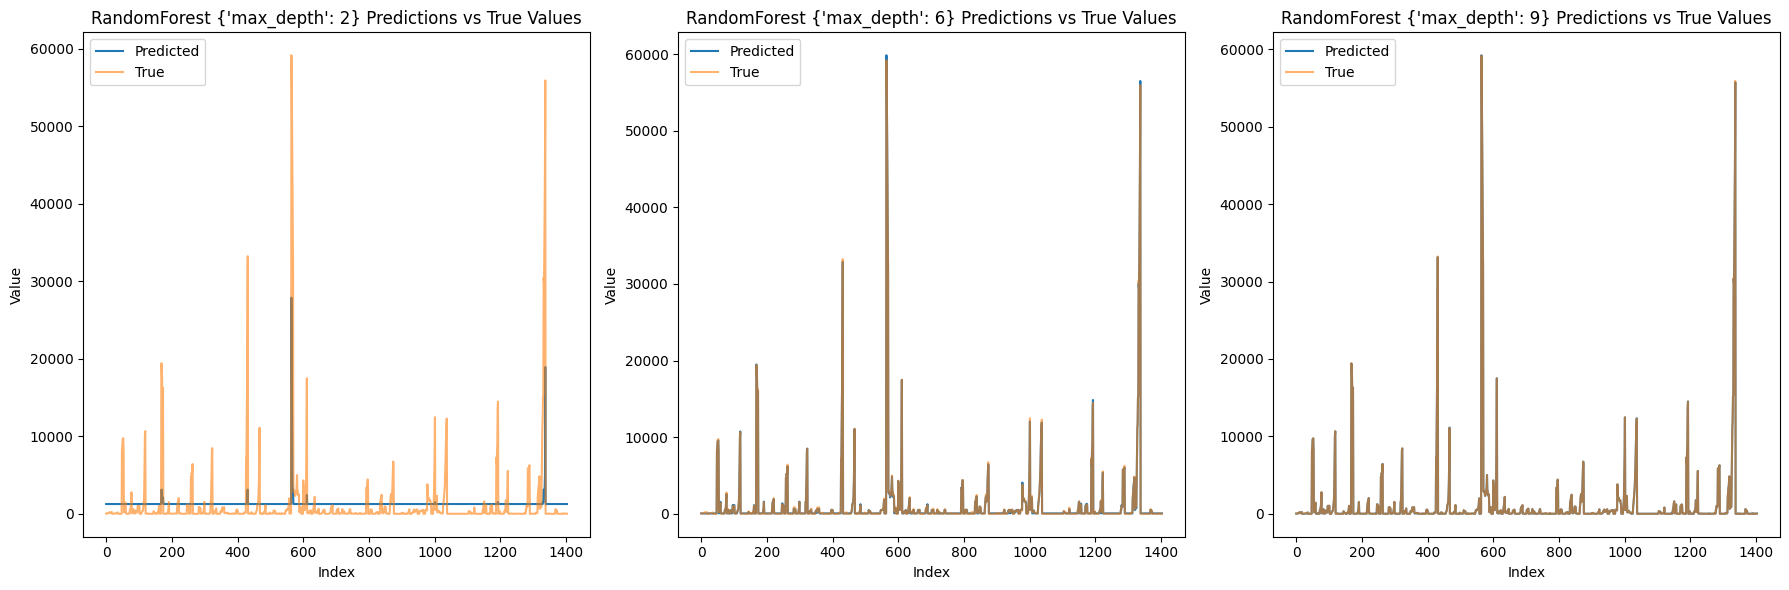

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

def evaluate_and_plot_models(models, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, rows_to_plot):
    results = []

    # Evaluate each model with its respective hyperparameters
    for model_info in models:
        model_type = model_info['type']
        hyperparameters = model_info['params']
        
        for hyperparam in hyperparameters:
            if model_type == 'RandomForest':
                model = RandomForestRegressor(**hyperparam, random_state=0)
            elif model_type == 'KNeighbors':
                model = KNeighborsRegressor(**hyperparam)
            else:
                raise ValueError("Unsupported model type")
            
            model_err_pred = evaluate_model(model, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name=model_type, monitoring=False)
            results.append((hyperparam,) + model_err_pred)

            print(f"Process for {model_type} with {hyperparam} done.")

    # Convert the list of results to a DataFrame
    if models[0]['type'] == 'RandomForest':
        columns = ["params", "MAE", "MSE", "y_pred", "y_test_rescaled"]
    elif models[0]['type'] == 'KNeighbors':
        columns = ["params", "MAE", "MSE", "y_pred", "y_test_rescaled"]
    
    tuning_data_df = pd.DataFrame(results, columns=columns)

    # Plotting
    fig, axs = plt.subplots(1, len(rows_to_plot), figsize=(18, 6))

    for i, row in enumerate(rows_to_plot):
        y_pred = tuning_data_df.loc[row, "y_pred"]
        y_test_rescaled = tuning_data_df.loc[row, "y_test_rescaled"]
        params = tuning_data_df.loc[row, "params"]
        model_name = f"{models[0]['type']} {params}"
        print(f"For {params}: MAE = {tuning_data_df.loc[row, 'MAE']} , MSE = {tuning_data_df.loc[row, 'MSE']}")
        plot_model(y_pred, y_test_rescaled, model_name, axs[i])

    plt.tight_layout()
    plt.show()

    return tuning_data_df

# Define the models and hyperparameters
models = [
    {
        'type': 'RandomForest',
        'params': [{'max_depth': depth} for depth in range(2, 10)]
    },
    {
        'type': 'KNeighbors',
        'params': [{'n_neighbors': k, 'p': p} for p in [1, 2, 3] for k in [2, 5, 10, 15]]
    }
]

# Call the function with the models and data
tuning_data_df = evaluate_and_plot_models(models, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, rows_to_plot=[0, 4, 7])


# TEST

In [ ]:
# ns_list, train_scores, validation_scores = learning_curve(
#                                                    estimator = SVR(**opt_svr_param), 
#                                                    X = X, y = Y, 
#                                                    train_sizes = ns_list, cv = 5,
#                                                    scoring = 'neg_mean_squared_error')


In [ ]:
# train_scores, valid_scores = validation_curve(KNeighborsRegressor(), X, Y, 
#                                               param_name="n_neighbors",
#                                               param_range=k_list , cv=20, 
#                                               scoring = 'neg_mean_squared_error',
#                                               verbose=1, n_jobs=-1
#                                              )
